In [15]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis


In [14]:
#Array packages
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


# 1. RE descrepencies


In [16]:
mdl=4
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc"]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
var_c=var+[f'{i}_C' for i in var]

gdf = gpd.read_file('DATA_p/Shapefiles/India_trans/India_trans_new.shp')
basin=np.array(gdf.iloc[:,2])

lsm = xr.open_mfdataset(f"DATA_p/{model[mdl]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm=lsm[['TotalPrecip_tavg','Evap_tavg','Qs_tavg']].compute()
lsm=lsm*60*60*24*30
#lsm=lsm.where(lsm>=0.0001,0)
#lsm=lsm.round(5)

RE=lsm["Qs_tavg"]/lsm["TotalPrecip_tavg"]

#1 No of nan values
A_count=np.sum(np.isnan(RE), axis=0)
nan_count=A_count.where(A_count<len(RE.time))
G=A_count.plot(vmin=0, vmax=100,add_colorbar=False);plt.colorbar(G,label='Total Nan value present in grids');plt.title(f'RE (ALL)')
plt.savefig(f'0_Datapreprocessing/outputs/nan_all_{model[mdl]}.png')
plt.close()

#2 No of inf values
inf_count=np.sum(np.isinf(RE), axis=0)
G=inf_count.plot(vmin=0, vmax=100,add_colorbar=False);plt.colorbar(G,label='Total Inf value present in grids');plt.title(f'RE (ALL)')
plt.savefig(f'0_Datapreprocessing/outputs/inf_all__{model[mdl]}.png')
plt.close()

#3 Greater than 1 RE values
anom_count=np.sum((lsm["Qs_tavg"]>lsm["TotalPrecip_tavg"]) & (lsm["TotalPrecip_tavg"]>0),axis=0)
G=anom_count.plot(vmin=0, vmax=100,add_colorbar=False);plt.colorbar(G,label='Total RE>1 present in grids');plt.title(f'RE (ALL)')
plt.savefig(f'0_Datapreprocessing/outputs/RElarge_all_{model[mdl]}.png')
plt.close()

,time,lon,lat,Qs
0,0,4,125,0.076643
1,0,5,124,0.085240
2,0,5,125,0.065456
3,0,5,126,0.056238
4,0,6,123,0.098738
...,...,...,...,...
13053010,503,319,295,0.000000
13053011,503,319,296,0.000000
13053012,503,319,297,0.000000
13053013,503,319,298,0.000000


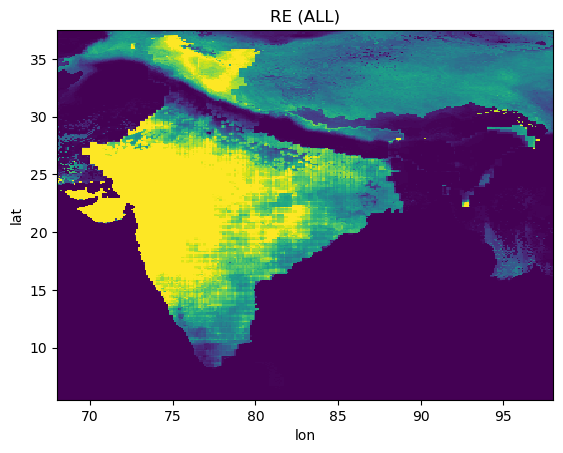

In [13]:
#3 Greater than 1 RE values
anom_count=np.sum((lsm["Qs_tavg"]>lsm["TotalPrecip_tavg"]),axis=0)
anom_count.plot(vmin=0, vmax=100,add_colorbar=False);plt.colorbar(G,label='Total RE>1 present in grids');plt.title(f'RE (ALL)')


ind=np.where((lsm["Qs_tavg"].values<0.1))
val_a=lsm["Qs_tavg"].values[ind]

list(zip(*ind,val_a))
pd.DataFrame(list(zip(*ind,val_a)),columns=['time','lon','lat','Qs'])

In [65]:

ind=np.where((RE>0.7)&(RE<1))
val_a=a[ind]
val_b=b[ind]
val_c=c[ind]
list(zip(*ind,val_a,val_b,val_c))
pd.DataFrame(list(zip(*ind,val_a,val_b,val_c)),columns=['time','lon','lat','Qs','PPT','RE'])

,time,lon,lat,Qs,PPT,RE
0,0,240,20,10.40,14.84,0.700809
1,0,246,31,12.13,12.91,0.939582
2,0,246,33,11.54,12.20,0.945902
3,0,246,34,11.25,11.94,0.942211
4,0,246,82,11.15,15.81,0.705250
...,...,...,...,...,...,...
267227,503,295,68,17.46,19.73,0.884947
267228,503,295,69,17.95,20.98,0.855577
267229,503,295,73,13.44,13.74,0.978166
267230,503,296,70,17.98,19.08,0.942348


In [52]:
#Extracting some points
a=lsm["Qs_tavg"].values
b=lsm["TotalPrecip_tavg"].values

ind=np.where((lsm["Qs_tavg"]>lsm["TotalPrecip_tavg"]) & (lsm["TotalPrecip_tavg"]>0))
val_a=a[ind]
val_b=b[ind]
val_c=c[ind]
list(zip(*ind,val_a,val_b,val_c))
pd.DataFrame(list(zip(*ind,val_a,val_b,val_c)),columns=['time','lon','lat','Qs','PPT','RE'])

,time,lon,lat,Qs,PPT,RE
0,0,32,100,0.11,0.03,3.666667
1,0,33,100,0.09,0.03,3.000000
2,0,34,100,0.06,0.02,3.000000
3,0,35,100,0.04,0.02,2.000000
4,0,35,101,0.19,0.03,6.333333
...,...,...,...,...,...,...
819670,503,319,193,0.01,0.01,1.000000
819671,503,319,194,0.01,0.01,1.000000
819672,503,319,195,0.01,0.01,1.000000
819673,503,319,196,0.01,0.01,1.000000


## 1.1Seasonal analysis

In [26]:
ss=0
mdl=4
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc"]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
var_c=var+[f'{i}_C' for i in var]

gdf = gpd.read_file('DATA_p/Shapefiles/India_trans/India_trans_new.shp')
basin=np.array(gdf.iloc[:,2])

lsm = xr.open_mfdataset(f"DATA_p/{model[mdl]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm=lsm[['TotalPrecip_tavg','Evap_tavg','Qs_tavg']].compute()
lsm=lsm*60*60*24*30
lsm=lsm.where(lsm>=1)
lsm=lsm.round(2)


for ss in range(4):
    lsm_ssn=lsm.sel(time=lsm["time.month"].isin(ssn_m[ss]))
    #lsm_ssn=lsm.groupby("time.year").mean(dim="year")
    
    RE=lsm_ssn["Qs_tavg"]/lsm_ssn["TotalPrecip_tavg"]
    
    #1 No of nan values
    A_count=np.sum(np.isnan(RE), axis=0)
    nan_count=A_count.where(A_count<len(RE.time))
    G=A_count.plot(vmin=0, vmax=40,add_colorbar=False);plt.colorbar(G,label='Total Nan value present in grids');plt.title(f'RE ({ssn[ss]})')
    plt.savefig(f'0_Datapreprocessing/outputs/nan_{ssn[ss]}_{model[mdl]}.png')
    plt.close()
    #2 No of inf values
    inf_count=np.sum(np.isinf(RE), axis=0)
    G=inf_count.plot(vmin=0, vmax=40,add_colorbar=False);plt.colorbar(G,label='Total inf value present in grids');plt.title(f'RE ({ssn[ss]})')
    plt.savefig(f'0_Datapreprocessing/outputs/inf_{ssn[ss]}_{model[mdl]}.png')
    plt.close()

    #3 Greater than 1 RE values
    anom_count=np.sum((lsm["Qs_tavg"]>lsm["TotalPrecip_tavg"]) & (lsm["TotalPrecip_tavg"]>0),axis=0)
    G=anom_count.plot(vmin=0, vmax=40,add_colorbar=False);plt.colorbar(G,label='Total RE>1 present in grids');plt.title(f'RE ({ssn[ss]})')
    plt.savefig(f'0_Datapreprocessing/outputs/RE_1_{ssn[ss]}_{model[mdl]}.png')
    plt.close()

In [301]:
lsm

<xarray.Dataset>
Dimensions:           (time: 504, lat: 320, lon: 300)
Coordinates:
  * time              (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
  * lat               (lat) float64 5.55 5.65 5.75 5.85 ... 37.25 37.35 37.45
  * lon               (lon) float64 68.05 68.15 68.25 ... 97.75 97.85 97.95
Data variables:
    TotalPrecip_tavg  (time, lat, lon) float32 nan nan nan nan ... 0.48 0.5 0.53
    Evap_tavg         (time, lat, lon) float32 nan nan nan ... 0.25 0.31 1.14
    Qs_tavg           (time, lat, lon) float32 nan nan nan nan ... 0.0 0.0 0.0

# 2 Best fit RE normalized

In [42]:
ss=0
mdl=4
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc"]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
var_c=var+[f'{i}_C' for i in var]

basin_new=np.array(['Brahmaputra_trans', 'Ganga_trans', 'Indus_trans', 'Brahmaputra','East_Flowing_M_G', 'Cauvery', 'East_Flowing_Cauvery','East_Flowing_G_K', 'EFR_PK1', 'EFR MP1',
       'Ganga', 'Godavari', 'Indus', 'Krishna', 'Mahanadi', 'Mahi','Narmada', 'Pennar', 'Sabarmati', 'Subarnarekha', 'Tapi','WFR TK', 'WFR KS', 'EFR MP2','EFR_PK2'])
gdf = gpd.read_file('DATA_p/Shapefiles/India_trans/India_trans_new.shp')
gdf.iloc[:,2]=basin_new

lsm = xr.open_mfdataset(f"DATA_p/{model[mdl]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm=lsm[['TotalPrecip_tavg','Evap_tavg','Qs_tavg']].compute()
lsm=lsm*60*60*24*30
lsm=lsm.where(lsm>=1)
lsm=lsm.round(2)

dataset=[]
for i in range(len(basin)):
    
    B=gdf[gdf['Basin'] == basin_new[i]]
    lsm.rio.set_spatial_dims(y_dim="lat",x_dim="lon", inplace=True)
    lsm.rio.write_crs("EPSG:4326", inplace=True)
    lsm_clip = lsm.rio.clip(B.geometry.apply(mapping), B.crs, drop=True)
    A=lsm_clip.mean(dim=['lat','lon']).expand_dims(dim='region')
    dataset.append(A)
    
lsm_R = xr.concat(dataset, dim='region')
lsm_R['region'] = basin

RE=lsm_R["Qs_tavg"]/lsm_R["TotalPrecip_tavg"]
RE=RE.where(~np.isinf(RE))
RE=RE.where(~(lsm_R["Qs_tavg"]>lsm_R["TotalPrecip_tavg"]))
lsm_R['RE']=RE


In [43]:
lsm_R

<xarray.Dataset>
Dimensions:           (time: 504, region: 25)
Coordinates:
  * time              (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
    spatial_ref       int32 0
  * region            (region) object 'Brahmaputra_trans' ... 'east_flowing_p...
Data variables:
    TotalPrecip_tavg  (region, time) float32 17.93 39.72 78.98 ... 522.8 60.16
    Evap_tavg         (region, time) float64 21.09 27.65 35.63 ... 89.52 119.5
    Qs_tavg           (region, time) float64 1.782 3.4 4.823 ... 151.6 10.63
    RE                (region, time) float64 0.09938 0.08561 ... 0.29 0.1766

# Practises

In [38]:
ss=0
mdl=4
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc"]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
var_c=var+[f'{i}_C' for i in var]

gdf = gpd.read_file('DATA_p/Shapefiles/India_trans/India_trans_new.shp')
basin=np.array(gdf.iloc[:,2])

lsm = xr.open_mfdataset(f"DATA_p/{model[mdl]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm=lsm[['TotalPrecip_tavg','Evap_tavg','Qs_tavg']]
lsm=lsm*60*60*24*30

lsm_re=lsm.where((lsm>=0.001)|(lsm.isnull()),0) #isnull is to make the outer location nans remains nan

#RE calculation
RE=lsm_re["Qs_tavg"]/lsm_re["TotalPrecip_tavg"]

#Preprocessing
#1. converting inf to nan (becasue inf effect all operation like mean, trend etc)
RE=RE.where(~np.isinf(RE))
RE=RE.where(~(lsm["Qs_tavg"]>lsm["TotalPrecip_tavg"]))    #Removed all RE>1
RE=RE.where(RE<0.7).compute()

#2. Now convert nan to value. First interpolate then the resedual nan you replace with mean values
#Attaching mean
#RE_mn=RE.groupby("time.month").mean()
#RE_mn = xr.concat([RE_mn]*len(np.unique(RE.time.dt.year)), dim="month")
#RE_mn1=RE_mn.rename({'month': 'time'});RE_mn1["time"]=RE.time
#RE_fin=RE.combine_first(RE_mn1)


#or run this
RE_fin=RE.interpolate_na(dim="time", method="linear",fill_value="extrapolate")
#RE_fin=RE.interpolate_na(dim="lat", method="linear",fill_value="extrapolate")

#lsm['RE']=RE

C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [30]:
RE_fin.isel(lat=120,lon=100).compute()
#RE.isel(lat=120,lon=100).compute()

<xarray.DataArray (time: 504)>
array([       nan, 0.        , 0.        , 0.00310413, 0.        ,
       0.03085808, 0.01023288, 0.03031471, 0.02557292, 0.00080397,
       0.        , 0.        , 0.00126052, 0.00393742, 0.00690114,
       0.        , 0.00123268, 0.03769066, 0.03603068, 0.0418857 ,
       0.10414394, 0.01745113, 0.00197161, 0.00194448, 0.00191735,
       0.00189284, 0.00186571, 0.00183945, 0.01347574, 0.01455216,
       0.0243039 , 0.01104718, 0.02068338, 0.04513057, 0.00205573,
       0.00279954, 0.00354335, 0.00421518, 0.00495898, 0.        ,
       0.01468645, 0.0120763 , 0.01489692, 0.06129188, 0.09755134,
       0.10218909, 0.00260837, 0.00962353, 0.00123309, 0.00102869,
       0.00074693, 0.01285773, 0.        , 0.00878117, 0.01209657,
       0.08845558, 0.02720539, 0.02284724, 0.        , 0.        ,
       0.        , 0.00613927, 0.01293632, 0.00225966, 0.00063005,
       0.02230389, 0.02112357, 0.02737106, 0.00323405, 0.01898458,
       0.01088908, 0.00252373, 0.01829139, 0.01513115, 0.        ,
       0.0051709 , 0.01094811, 0.01653896, 0.01220047, 0.04291406,
       0.00585568, 0.00073571, 0.00280722, 0.00304276, 0.00078981,
       0.00134268, 0.00478566, 0.00095785, 0.0014774 , 0.00418075,
       0.02723278, 0.0124332 , 0.00738991, 0.01116528, 0.05649887,
       0.        , 0.00514394, 0.00995602, 0.        , 0.00656599,
...
       0.0485245 , 0.02581632, 0.        , 0.        , 0.        ,
       0.02087651, 0.00137541, 0.02240707, 0.02343144, 0.01709383,
       0.02252908, 0.02365073, 0.00804681, 0.02465077, 0.        ,
       0.0161557 , 0.02054323, 0.02540084, 0.02265141, 0.00247255,
       0.01146597, 0.01289577, 0.00521196, 0.01537082, 0.00474746,
       0.        , 0.        , 0.        , 0.00030267, 0.00062621,
       0.00061947, 0.00820606, 0.00738243, 0.01208007, 0.01253773,
       0.05764669, 0.03168615, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00231257, 0.00279915, 0.01246434,
       0.02726763, 0.03548102, 0.0202198 , 0.02123869, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0117966 ,
       0.00195152, 0.01293118, 0.00745333, 0.00696973, 0.00311946,
       0.010941  , 0.01517836, 0.01955696, 0.0031011 , 0.        ,
       0.        , 0.00106036, 0.00120388, 0.0036744 , 0.00291324,
       0.01232983, 0.01333918, 0.00548674, 0.        , 0.00092967,
       0.00217177, 0.00089868, 0.0006829 , 0.00204612, 0.00150772,
       0.00623437, 0.01644096, 0.01757948, 0.03641358, 0.20081637,
       0.00300501, 0.00380267, 0.00460033, 0.        , 0.        ,
       0.00704047, 0.00520966, 0.01267886, 0.02662789, 0.00968124,
       0.03327948, 0.01207591, 0.00161472,        nan])
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
    spatial_ref  int64 0
    lat          float64 17.55
    lon          float64 78.05

Text(0.5, 1.0, 'RE (ALL)')

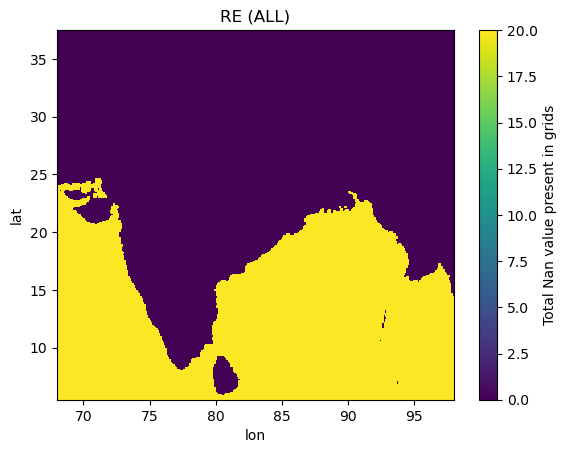

In [39]:
#2 No of inf values

A_count=np.sum(np.isnan(RE_fin), axis=0)
nan_count=A_count.where(A_count<len(RE.time))
G=A_count.plot(vmin=0, vmax=20,add_colorbar=False);plt.colorbar(G,label='Total Nan value present in grids');plt.title(f'RE (ALL)')